In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

#-----------------------Imports from Sktime-------------------------
from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster, make_reduction
import pandas as pd

In [40]:
data = pd.read_csv('time/time0.csv', index_col=3)

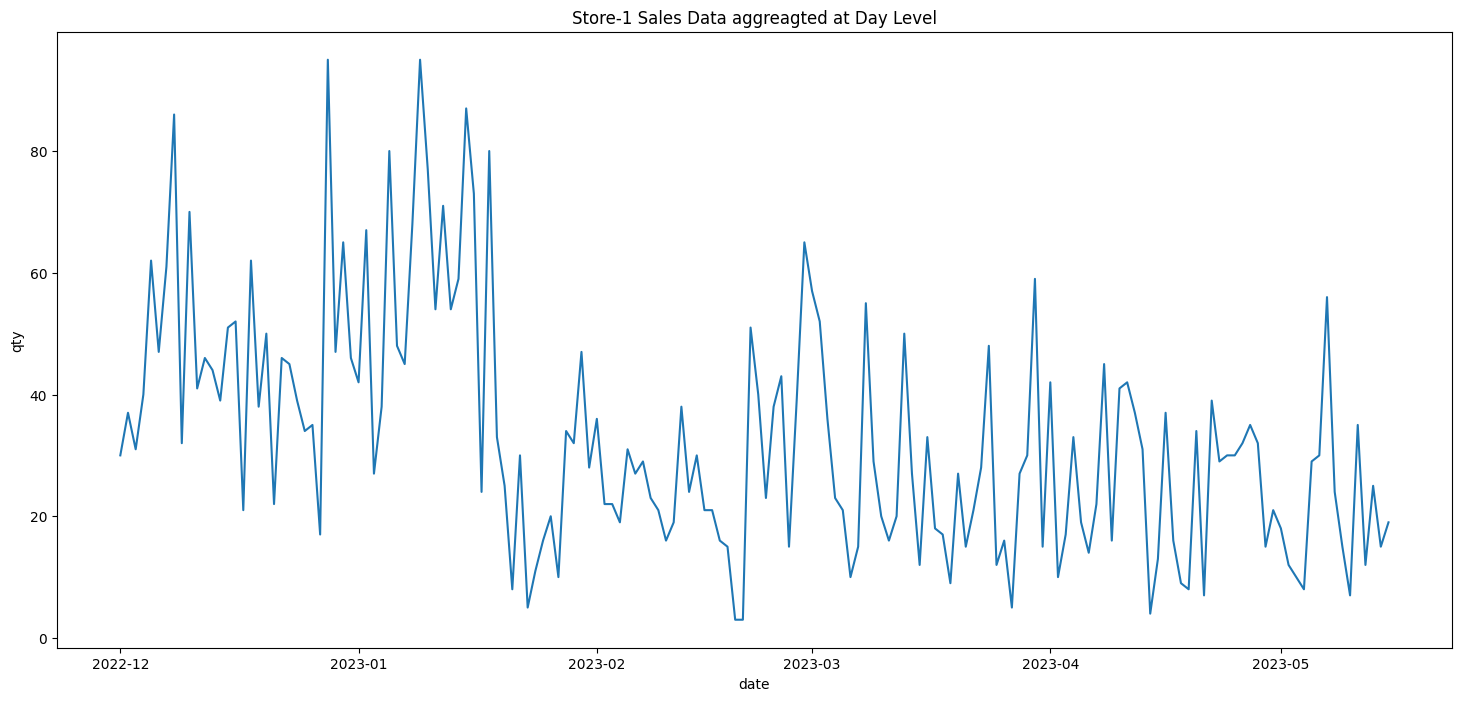

In [41]:
#--------------------------Data Preparation-------------------------
#For the sake of demonstration, we will train our model on monthly aggregated Sales data of a particular store
# Select sales for Store 1 Only.
store1_agg = data['qty']
store1_agg.index = pd.to_datetime(store1_agg.index)
#Aggregate the Data on a Monthly basis.
store1_agg_monthly = store1_agg.resample('D').sum()
#--------------------Visulaize Data on a Time Plot------------------
sns.lineplot(
    data=store1_agg_monthly, 
)
plt.title("Store-1 Sales Data aggreagted at Day Level")
plt.show()

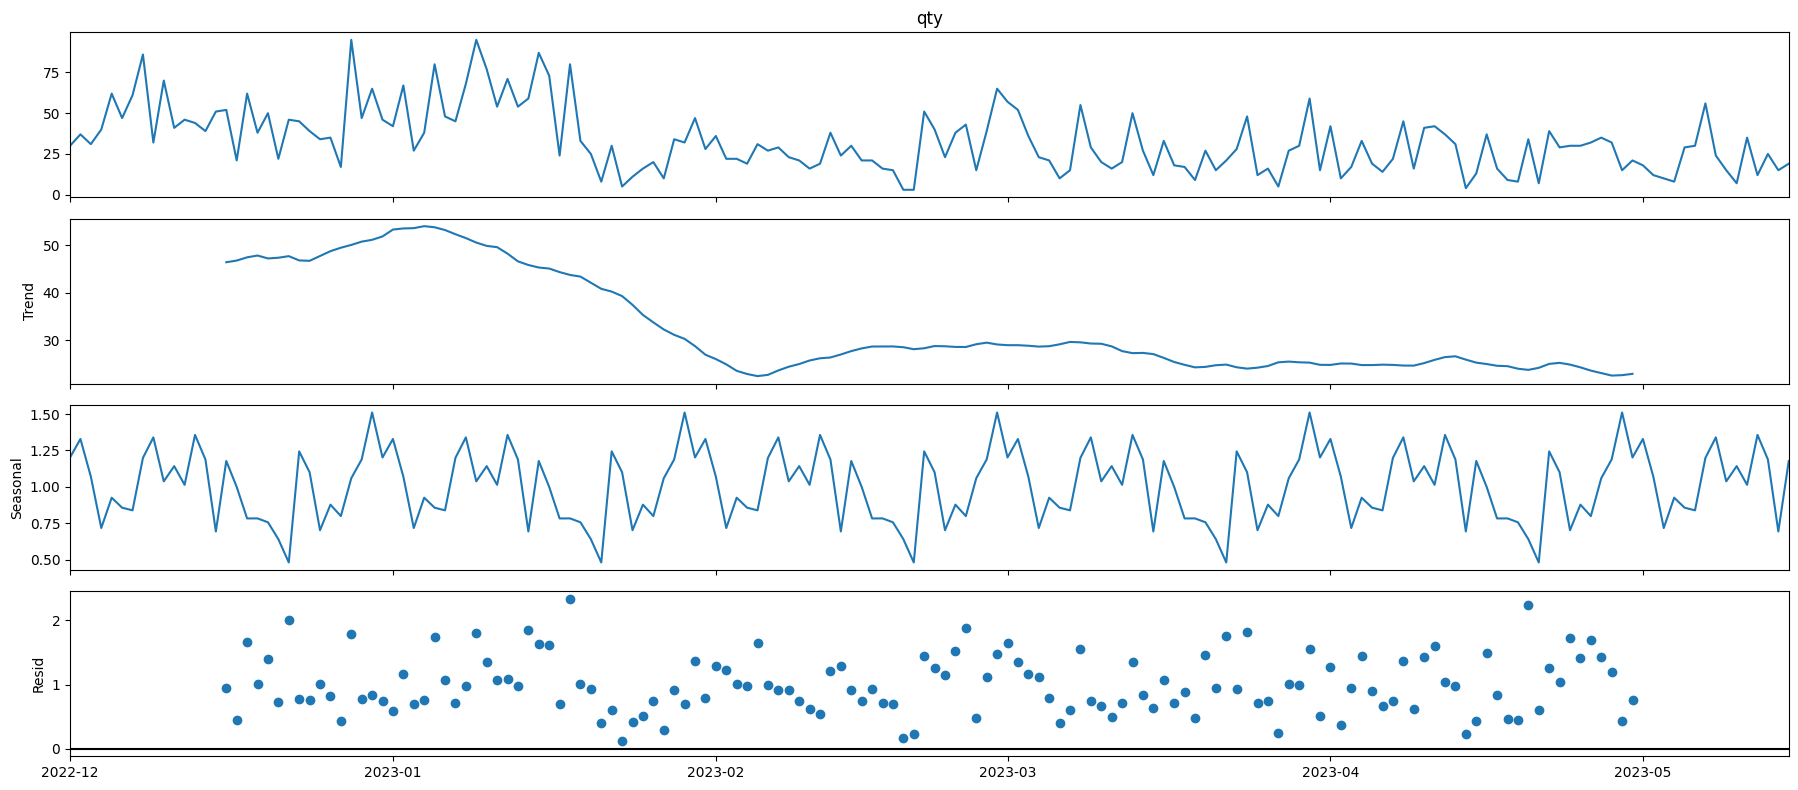

In [42]:
seasonal_decompose(store1_agg_monthly,model="multiplicative",period=30).plot()
plt.show()

In [43]:
store1_agg_monthly.index = store1_agg_monthly.index.to_period('D') 
y_train, y_test = temporal_train_test_split(store1_agg_monthly, test_size=0.2)

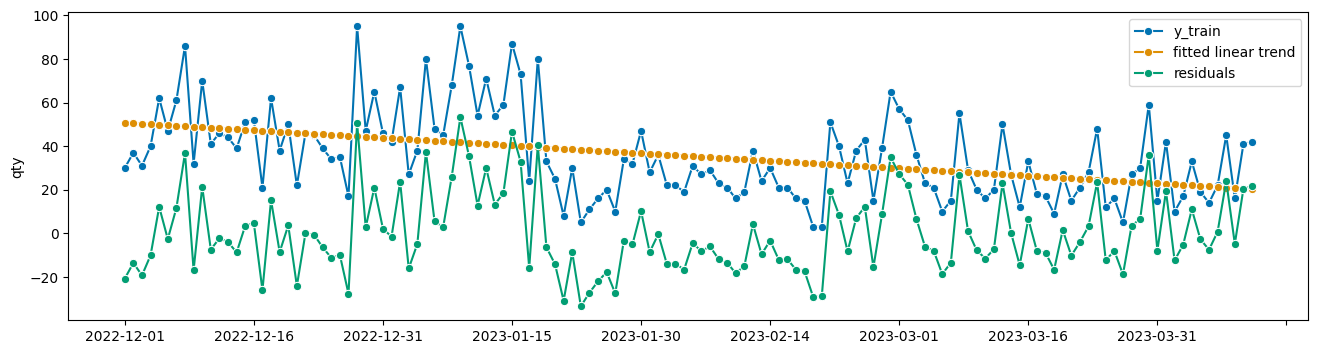

In [44]:
forecaster = PolynomialTrendForecaster(degree=1) 
transformer = Detrender(forecaster=forecaster)
#Get the residuals after fitting a linear trend
y_resid = transformer.fit_transform(y_train)
# Internally, the Detrender uses the in-sample predictions
# of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)
plot_series(y_train, y_pred, y_resid, labels=["y_train", "fitted linear trend", "residuals"]);

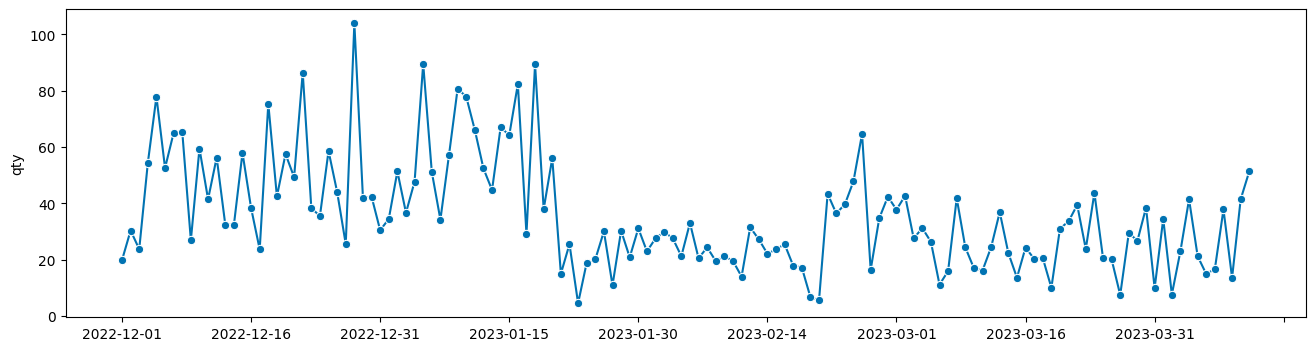

In [45]:
deseasonalizer = Deseasonalizer(model="multiplicative", sp=30)
plot_series(deseasonalizer.fit_transform(y_train))
seasonal = deseasonalizer.fit_transform(y_train)

In [67]:
def get_transformed_target_forecaster(alpha,params):
    
    #Initialize Light GBM Regressor 
    
    regressor = lgb.LGBMRegressor(alpha = alpha,**params)
#-----------------------Forecaster Pipeline-----------------
    
    #1.Separate the Seasonal Component.
    #2.Fit a forecaster for the trend.
    #3.Fit a Autoregressor to the resdiual(autoregressing on four historic values).
    
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalise", Deseasonalizer(model="multiplicative", sp=30)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
            (
                # Recursive strategy for Multi-Step Ahead Forecast.
                # Auto Regress on four previous values
                "forecast",
                make_reduction(
                    estimator=regressor, window_length=4, strategy="recursive",
                ),
            ),
        ]
    )
    return forecaster

In [68]:
#-------------------Fitting an Auto Regressive Light-GBM------------
#Setting Quantile Regression Hyper-parameter.
params = {
    'objective':'quantile'
}
#A 10 percent and 90 percent prediction interval(0.1,0.9 respectively).
quantiles = [.1, .5, .9] #Hyper-parameter "alpha" in Light GBM
#Capture forecasts for 10th/median/90th quantile, respectively.
forecasts = []
#Iterate for each quantile.
for alpha in quantiles:
    
    forecaster = get_transformed_target_forecaster(alpha,params)
    
    #Initialize ForecastingHorizon class to specify the horizon of forecast
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    #Fit on Training data.
    forecaster.fit(y_train)
    
    #Forecast the values.
    y_pred = forecaster.predict(fh)
    
    #List of forecasts made for each quantile.
    y_pred.index.name="date"
    y_pred.name=f"predicted_sales_q_{alpha}"
    forecasts.append(y_pred)
    
#Append the actual data for plotting.
store1_agg_monthly.index.name = "date"
store1_agg_monthly.name = "original"
forecasts.append(store1_agg_monthly)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 128, number of used features: 4
[LightGBM] [Info] Start training from score -16.501963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [70]:

def wmapes(y_true, y_pred):
    return 1 - np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)
wmapes(y_test, y_pred)

-0.15041339264716602

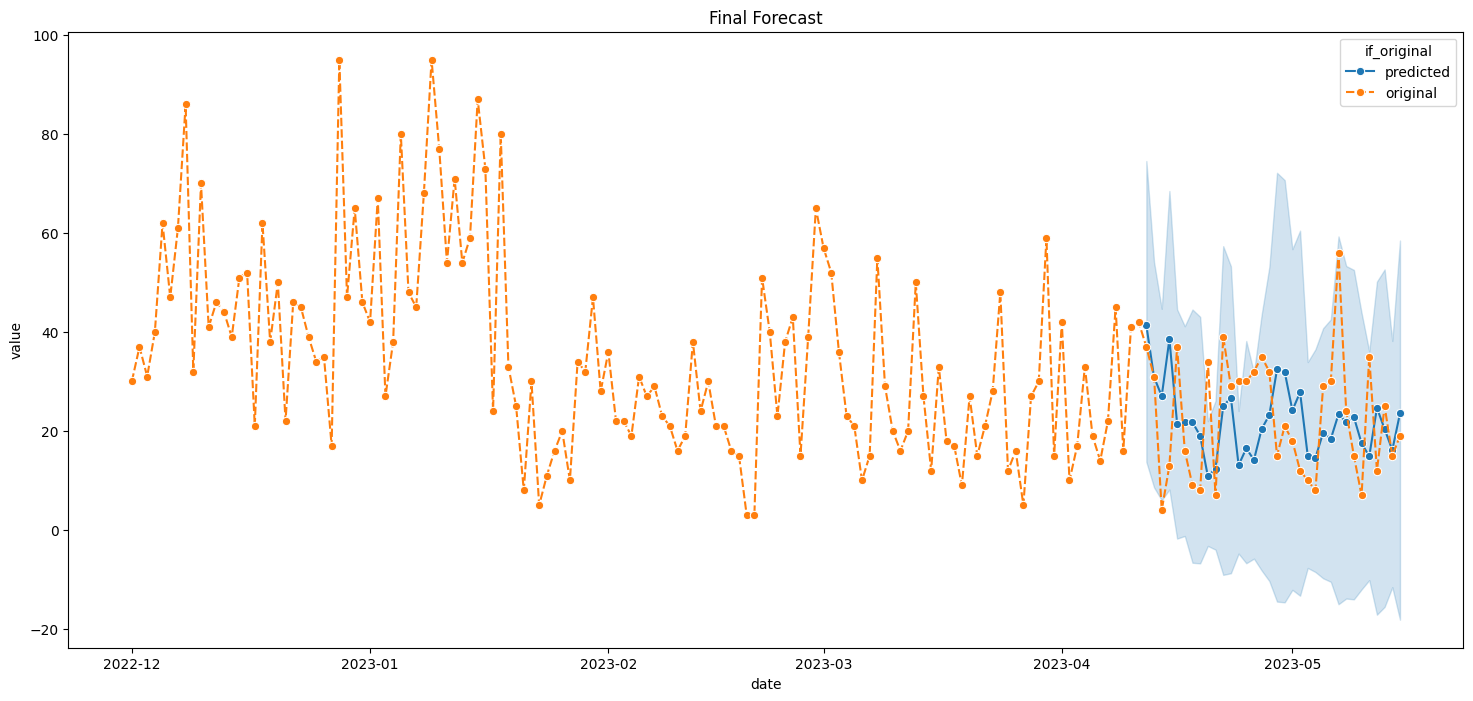

In [69]:
plot_data = pd.melt(pd.concat(forecasts,axis=1).reset_index(), id_vars=['date'],\
        value_vars=['predicted_sales_q_0.1', 'predicted_sales_q_0.5',
                   'predicted_sales_q_0.9','original'])
plot_data['date'] = pd.to_datetime(plot_data['date'].astype(str).to_numpy())
plot_data['if_original'] = plot_data['variable'].apply(
    lambda r:'original' if r=='original' else 'predicted' 
)
sns.lineplot(data = plot_data,
        x='date',
        y='value',
        hue='if_original',
             style="if_original",
        markers=['o','o'],
)
plt.title("Final Forecast")
plt.show()